# Function Approximation

This notebook demonstrates how to use a neural network to approximate a mathematical function. We will approximate the function $f(x) = \sin(x) \cdot \cos(2x)$ in the range $[-\pi, \pi]$.

The notebook covers data generation, neural network construction, training, and performance evaluation, providing insights into how neural networks can learn to approximate nonlinear functions.

## Code Implementation

### Importing the Neural Network Library

First, import the necessary classes from the `neural_network` library, as well as supporting libraries for data handling and visualization.

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from neural_network.layer import HiddenLayer, InputLayer, OutputLayer
from neural_network.math.activation_functions import LinearActivation, TanhActivation
from neural_network.neural_network import NeuralNetwork

logging.basicConfig(format="%(asctime)s %(message)s", datefmt="[%d-%m-%Y|%H:%M:%S]", level=logging.INFO)
logger = logging.getLogger(__name__)
rng = np.random.default_rng()


In [2]:
# Neural network parameters
HIDDEN_LAYER_SIZES = [32, 16, 8]
INPUT_ACTIVATION = LinearActivation
HIDDEN_ACTIVATION = TanhActivation
OUTPUT_ACTIVATION = LinearActivation
WEIGHTS_RANGE = (-1, 1)
BIAS_RANGE = (-0.1, 0.1)
LR = 0.01

# Dataset parameters
DATASET_SIZE = 2000
TRAIN_SIZE_RATIO = 0.8
NUM_EPOCHS = 100

# Function parameters
X_RANGE = (-np.pi, np.pi)

### Define the Target Function and Generate Data

In this section, we define the target function $f(x) = \sin(x) \cdot \cos(2x)$ that our neural network will learn to approximate. 

We'll also create functions to:
- Generate training data points from this function
- Split the data into training and testing sets
- Calculate errors between expected and actual outputs
- Shuffle the dataset for better training

These utility functions are essential for supervised learning.

In [3]:
def target_function(x: float) -> float:
    """Compute the target function value for a given input.

    :param float x:
        Input value.
    :return float:
        Output value of the target function.
    """
    return np.sin(x) * np.cos(2 * x)


def training_data_from_num(num: int) -> tuple[float, float]:
    """Generate target function outputs from a number to use in training.

    :param int num:
        Number to use for training data.
    :return tuple[list[float], float]:
        Input and expected output.
    """
    return ([num / np.pi], target_function(num))


def generate_training_data(dataset_size: int, x_range: tuple[float, float]) -> list[tuple[float, float]]:
    """Generate a supervised dataset for training.

    :param int dataset_size:
        The number of data points to generate.
    :param tuple[float, float] x_range:
        The range of x values to use for generating the dataset.
    :return list[tuple[list[float], float]]:
        List of (input, output) pairs.
    """
    x = np.linspace(*x_range, dataset_size)
    return [training_data_from_num(num) for num in x]


def shuffle_data(data: list[tuple[float, float]]) -> list[tuple[float, float]]:
    """Shuffle the dataset.

    :param list[tuple[float, float]] data:
        The dataset to shuffle.
    :return list[tuple[float, float]]:
        The shuffled dataset.
    """
    rng.shuffle(data)
    return data


def split_data(
    data: list[tuple[float, float]], train_size_ratio: float = TRAIN_SIZE_RATIO
) -> tuple[list[tuple[float, float]], list[tuple[float, float]]]:
    """Split the dataset into training and testing sets.

    :param list[tuple[float, float]] data:
        The dataset to split.
    :param float train_size_ratio:
        The proportion of the dataset to include in the training split.
    :return tuple[list[tuple[float, float]], list[tuple[float, float]]]:
        Training and testing datasets.
    """
    train_size = int(len(data) * train_size_ratio)
    data = shuffle_data(data)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data


def calculate_errors(expected_outputs: np.ndarray, actual_outputs: np.ndarray) -> np.ndarray:
    """Calculate the error between expected and actual outputs.

    :param np.ndarray expected_outputs:
        The expected output values.
    :param np.ndarray actual_outputs:
        The actual output values.
    :return np.ndarray:
        The calculated errors.
    """
    return expected_outputs - actual_outputs


def calculate_percentage_error(errors: np.ndarray) -> float:
    """Calculate the percentage error from a list of errors.

    :param np.ndarray errors:
        The list of errors.
    :return float:
        The average error as a percentage.
    """
    avg_error = np.average(errors)
    return np.abs(avg_error) * 100

### Neural Network Creation

The following functions are used to create and test neural networks using the parameters defined earlier in this notebook.

In [4]:
def create_nn(
    hidden_layer_sizes: list[int] = HIDDEN_LAYER_SIZES,
    input_activation: type = INPUT_ACTIVATION,
    hidden_activation: type = HIDDEN_ACTIVATION,
    output_activation: type = OUTPUT_ACTIVATION,
    weights_range: tuple[float, float] = WEIGHTS_RANGE,
    bias_range: tuple[float, float] = BIAS_RANGE,
    lr: float = LR,
) -> NeuralNetwork:
    """Create a neural network with specified parameters.

    :param list[int] hidden_layer_sizes:
        Sizes of hidden layers.
    :param type input_activation:
        Activation function for input layer.
    :param type hidden_activation:
        Activation function for hidden layers.
    :param type output_activation:
        Activation function for output layer.
    :param tuple[float, float] weights_range:
        Range for initializing weights.
    :param tuple[float, float] bias_range:
        Range for initializing biases.
    :param float lr:
        Learning rate.
    :return NeuralNetwork:
        Constructed neural network.
    """
    input_layer = InputLayer(size=1, activation=input_activation)
    hidden_layers = [
        HiddenLayer(size=size, activation=hidden_activation, weights_range=weights_range, bias_range=bias_range)
        for size in hidden_layer_sizes
    ]
    output_layer = OutputLayer(size=1, activation=output_activation, weights_range=weights_range, bias_range=bias_range)

    return NeuralNetwork.from_layers(layers=[input_layer, *hidden_layers, output_layer], lr=lr)


def evaluate_nn(nn: NeuralNetwork, data: list[tuple[list[float], float]]) -> tuple[np.ndarray, float]:
    """Evaluate the neural network on a dataset.

    :param NeuralNetwork nn:
        The neural network to evaluate.
    :param list[tuple[list[float], float]] data:
        The dataset to evaluate on.
    :return tuple[np.ndarray, float]:
        List of errors and average error as a percentage.
    """
    dataset_size = len(data)
    outputs = []
    expected = []

    for i in range(dataset_size):
        inputs = data[i][0]
        expected_output = data[i][1]
        output = nn.feedforward(inputs)[0]
        outputs.append(output)
        expected.append(expected_output)

    errors = calculate_errors(expected_outputs=np.array(expected), actual_outputs=np.array(outputs))
    percentage_error = calculate_percentage_error(errors)
    return errors, percentage_error

### Testing and Visualization

We can use `matplotlib` to create a graph to plot the outputs of the neural network after training.

In [5]:
def plot_results(neural_networks: dict[str, NeuralNetwork], title: str) -> None:
    """Plot the results of the neural network against the target function.

    :param dict[str, NeuralNetwork] neural_networks:
        Dictionary of neural networks to plot.
    :param str title:
        The title of the plot.
    """
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.xlim(*X_RANGE)

    x = np.linspace(*X_RANGE, 100)
    y_true = [target_function(num) for num in x]
    plt.plot(x, y_true, label="Target Function")

    for name, nn in neural_networks.items():
        y_pred = [nn.feedforward([num / np.pi])[0] for num in x]
        plt.plot(x, y_pred, label=name)

    plt.legend()
    plt.grid()
    plt.show()

### Training the Neural Network

Now we can run the training algorithm and test the neural network to evaluate its accuracy.
We will test different neural network architectures and plot the outputs to compare the accuracy of each neural network.

In [6]:
nn_dict = {
    "Small": create_nn(hidden_layer_sizes=[8, 4, 2]),
    "Medium": create_nn(hidden_layer_sizes=[16, 8, 4]),
    "Large": create_nn(hidden_layer_sizes=[32, 16, 8]),
}

logger.info("Generating dataset with %s data points...", DATASET_SIZE)
data_supervised = generate_training_data(DATASET_SIZE, X_RANGE)
training_data_supervised, testing_data_supervised = split_data(data_supervised)
logger.info(
    "Will use %s data points for training and %s data points for testing.",
    len(training_data_supervised),
    len(testing_data_supervised),
)

logger.info("Each neural network will be trained for %s epochs.", NUM_EPOCHS)

for name, nn in nn_dict.items():
    logger.info("BEGINNING TRAINING FOR NEURAL NETWORK: %s", name)
    nn.run_supervised_training(
        inputs=[input_data for input_data, _ in training_data_supervised],
        expected_outputs=[expected_output for _, expected_output in training_data_supervised],
        epochs=NUM_EPOCHS,
    )

    _, percentage_error = evaluate_nn(nn, testing_data_supervised)
    logger.info("Error: %.4f%%", percentage_error)


[11-06-2025|21:22:56] Generating dataset with 2000 data points...
[11-06-2025|21:22:56] Will use 1600 data points for training and 400 data points for testing.
[11-06-2025|21:22:56] Each neural network will be trained for 100 epochs.
[11-06-2025|21:22:56] BEGINNING TRAINING FOR NEURAL NETWORK: Small
[11-06-2025|21:23:18] Error: 1.6070%
[11-06-2025|21:23:18] BEGINNING TRAINING FOR NEURAL NETWORK: Medium
[11-06-2025|21:23:43] Error: 1.8758%
[11-06-2025|21:23:43] BEGINNING TRAINING FOR NEURAL NETWORK: Large
[11-06-2025|21:24:16] Error: 0.5334%


We can visualise the results by comparing the neural network outputs with the actual outputs of the target function.

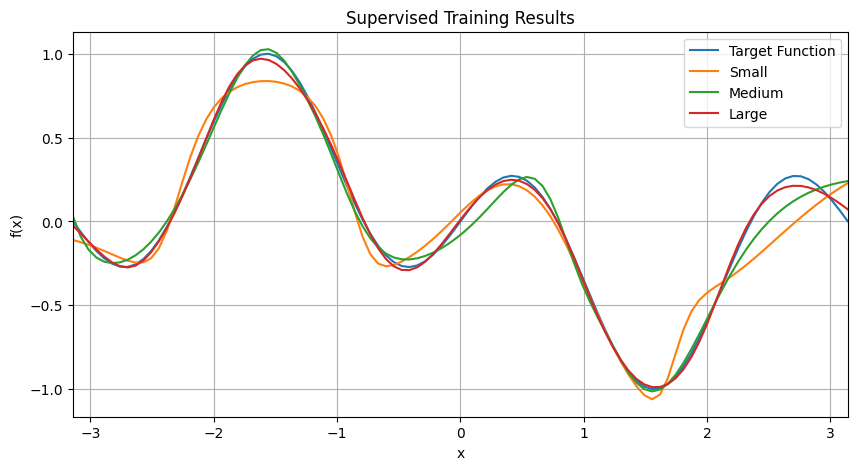

In [7]:
plot_results(nn_dict, "Supervised Training Results")